<center>
<h1>
Analyzing the Sentiment of Substance Abuse Support Groups During the COVID-19 Pandemic via Natural Language Processing
</h1>
<h5>
<a href="https://zeyadmansour.com">Zeyad Mansour</a> 
</h5>
</center>

# 1 Scraping / Data Collection

## 1.1 Installing dependencies and importing the basic ones

<p> Although not shown here, it is recommended that the following packages are installed in a conda virtual environment. The jupyter kernel also must be installed in the environment. </p>

In [26]:
!pip install -r requirements.txt

Looking in links: https://download.pytorch.org/whl/cu113


<hr>


In [55]:
from calendar import monthrange
from collections import Counter

# the datetime object allows for easy chronological organization of the dataframe 
from datetime import datetime
import json

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import os

# the data retrieved from the API is stored in a pandas dataframe
import pandas as pd

# python wrapper for the official reddit api
import praw 

# python wrapper for the pushshift api
from psaw import PushshiftAPI 

import random
import seaborn
import statistics
import sys
import time
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /home/zeyad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zeyad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1.2 Authenticating with the Reddit API 

In [2]:
# client_secrets.json file must be created to contain credentials
# ex_client_secrets.json contains the example credentials format
f = open('client_secrets.json') 
 
client_secrets = json.load(f)

r = praw.Reddit(client_id=client_secrets["client_id"],
    client_secret=client_secrets["client_secret"],
    username=client_secrets["username"],
    password=client_secrets["password"],
    user_agent=client_secrets["user_agent"]
)

api = PushshiftAPI(r)

## 1.3 Scraping via Requests to the API 

In [5]:
subreddits = ["addiction", "alcoholism", "benzorecovery", "leaves", "OpiatesRecovery", "quittingkratom", 
              "QuittingPhenibut", "redditorsinrecovery",  "StopDrinking", "StopSmoking", "StopSpeeding"]  
start_year = 2019
start_month = 10
end_year = 2022
end_month = 2

In [4]:
def save_posts_by_month(subreddit, year, month, limit=100000):
    ''' 
    Scrapes and saves all posts from the specified subreddit to a CSV file
    given a particular month in the "year-month" format
    '''
    num_days = monthrange(year, month)[1]
    after=int(datetime(year, month, 1).timestamp())
    before=int(datetime(year, month, num_days).timestamp()) 
    print(f"Scraping posts from /r/{subreddit} [{year}, {month}]...")
    gen = api.search_submissions(after=after, before=before, subreddit=subreddit, limit=limit)
    post_list = []
    for e in gen:
        submission = r.submission(e)
        post_list.append({"Date": datetime.fromtimestamp(submission.created_utc), "URL": submission.url, "Title": submission.title, "Body": submission.selftext, "Score": submission.score})
        
    df = pd.DataFrame(post_list)
    df.to_csv(f"data/{subreddit}/{subreddit}_{year}-{month}.csv", index = False, header = True)
    
def iter_months(start_year, start_month, end_year, end_month):
    ''' 
    Yields the dates of months in the "year-month" format given time interval 
    '''   
    while (start_year == end_year and start_month <= end_month) or (start_year < end_year):
        if start_month < 12:
            yield {"year":start_year, "month":start_month}
            start_month += 1
        else:
            yield {"year":start_year, "month":start_month}
            start_year += 1
            start_month = 1

In [4]:
def scrape_posts(subreddits, start_year, start_month, end_year, end_month):
    print(f"{len(subreddits)} subreddits selected")

    datadir = 'data'
    try:
        os.mkdir('data')
        print(f"Directory '{datadir}' was created") 
    except FileExistsError:
        print(f"Directory '{datadir}' already exists")
        
    for subreddit in subreddits:
        datadir = f"data/{subreddit}"
        try:
            os.mkdir(datadir)
            print(f"Directory '{datadir}' was created") 
        except FileExistsError:
            print(f"Directory '{datadir}' already exists")
            continue
            
        for date in iter_months(start_year, start_month, end_year, end_month):
            save_posts_by_month(subreddit, date["year"], date["month"])
       

scrape_posts(subreddits, start_year, start_month, end_year, end_month)

11 subreddits selected
Directory 'data' already exists
Directory 'data/addiction' already exists
Directory 'data/alcoholism' already exists
Directory 'data/benzorecovery' already exists
Directory 'data/leaves' already exists
Directory 'data/OpiatesRecovery' already exists
Directory 'data/quittingkratom' already exists
Directory 'data/QuittingPhenibut' already exists
Directory 'data/redditorsinrecovery' already exists
Directory 'data/StopDrinking' already exists
Directory 'data/StopSmoking' already exists
Directory 'data/StopSpeeding' already exists


## 1.4 Data Preprocessing

In [34]:
#Delete the posts that were either deleted or removed
deleted_keywords = ["deleted", "removed"]
data_metrics = {"num_posts":0}

    
for subreddit in subreddits: 
    for date in iter_months(start_year, start_month, end_year, end_month): 
        filename = f'data/{subreddit}/{subreddit}_{date["year"]}-{date["month"]}.csv'
        indicies_to_delete = list()
        df = pd.read_csv(filename) 
        for index, row in df.iterrows():
            for e in deleted_keywords:
                if e in str(row["Title"]) or e in str(row["Body"]):
                    indicies_to_delete.append(index)
                    
        df = df.drop(labels=indicies_to_delete, axis=0)
        df = df.reset_index()
        df = df.drop(labels="index", axis=1)
        data_metrics["num_posts"] += len(df)
        df.to_csv(filename, index=False)

print("Finished removing the posts that were either deleted or removed.")
print(f"Data metrics: {data_metrics}")

Finished removing the posts that were either deleted or removed.
Data metrics: {'num_posts': 244450}


In [148]:
#pick the first month of the first subreddit
filename = f'data/{subreddits[0]}/{subreddits[0]}_{start_year}-{start_month}.csv'
df = pd.read_csv(filename) 
print(filename)
display(df)

data/addiction/addiction_2019-10.csv


,Date,URL,Title,Body,Score
0,2019-10-30 22:35:14,https://www.reddit.com/r/addiction/comments/dp...,I'm committed to making a change...,Last week I came out to my wife and shared wit...,5
1,2019-10-30 22:16:46,https://www.reddit.com/r/addiction/comments/dp...,"If I could use successfully forever, I would",I didn’t quit because it was the right thing t...,1
2,2019-10-30 19:04:33,https://www.reddit.com/r/addiction/comments/dp...,I'm wondering if it's a bad idea for an alcoho...,NaN,2
3,2019-10-30 18:35:13,https://www.reddit.com/r/addiction/comments/dp...,Septum Hole Question,Throwaway. Could really use some help here.\n\...,1
4,2019-10-30 14:57:27,https://www.reddit.com/r/addiction/comments/dp...,My sister (13) is using drugs,"It says it in the title, my sister is getting ...",1
...,...,...,...,...,...
277,2019-10-01 09:39:39,https://www.reddit.com/r/addiction/comments/db...,Day 2 sober,Yesterday was my first day sober in years I fe...,4
278,2019-10-01 09:00:43,https://www.reddit.com/r/addiction/comments/db...,Leading to a habit or just being a pig ?,Last few months I’ve been hitting speed or mdm...,2
279,2019-10-01 06:14:51,https://www.reddit.com/r/addiction/comments/db...,110 days sober until today,Stress. Idk what to say. Thought I had it this...,11
280,2019-10-01 02:16:04,https://www.reddit.com/r/cocaine/comments/dbmn...,Today I shot up WAY too much cocaine and I got...,NaN,2


<hr>

# 2 Trend Analysis

## 2.1 Get case data

In [149]:
#intialize a dates list since this will be useful for future steps
dates = list()
for date in iter_months(start_year, start_month, end_year, end_month): 
    if date["month"] < 10:
        dates.append(f'{date["year"]}-0{date["month"]}')
    else:
        dates.append(f'{date["year"]}-{date["month"]}')

Refer to the [Johns Hopkins COVID-19 GitHub repository](https://github.com/CSSEGISandData/COVID-19). 

In [43]:
#Look at the dataframes to see how they are organized so that we can group it by the total number of new cases for each month.

print("United States:")
df = pd.read_csv('data/time_series_covid19_confirmed_US.csv')
display(df)
print("Global:")
df = pd.read_csv('data/time_series_covid19_confirmed_global.csv')
display(df)

United States:


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/9/22,4/10/22,4/11/22,4/12/22,4/13/22,4/14/22,4/15/22,4/16/22,4/17/22,4/18/22
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,15744,15744,15747,15749,15751,15751,15752,15752,15752,15771
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,55489,55489,55499,55512,55522,55536,55547,55547,55547,55579
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,5658,5658,5658,5658,5658,5658,5658,5658,5658,5659
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,6422,6422,6425,6425,6425,6428,6428,6428,6428,6428
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,14929,14929,14934,14934,14935,14953,14959,14959,14959,14963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,9932,9932,9932,9945,9945,9945,9945,9945,9945,9945
3338,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,5634,5634,5634,5624,5624,5624,5624,5624,5624,5624
3339,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3340,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,2358,2358,2358,2357,2357,2357,2357,2357,2357,2357


Global:


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/9/22,4/10/22,4/11/22,4/12/22,4/13/22,4/14/22,4/15/22,4/16/22,4/17/22,4/18/22
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,177974,177974,178141,178257,178295,178352,178373,178387,178418,178457
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,274191,274219,274219,274272,274320,274376,274429,274462,274504,274520
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,265720,265724,265727,265730,265731,265733,265738,265739,265739,265741
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,40328,40328,40328,40328,40709,40709,40709,40709,40709,40709
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,99194,99194,99194,99194,99194,99194,99194,99194,99194,99194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,656287,656287,656287,656617,656617,656617,656617,656617,656617,656617
280,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
281,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,11813,11813,11814,11814,11815,11815,11817,11817,11817,11818
282,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,317483,317483,317804,317804,318113,318229,318404,318467,318515,318515


In [45]:
def get_monthly_cases(df):
    #intitialize the list with 0's for the first 3 months where no data was collected
    monthly_covid_cases = [0, 0, 0]
    curr_month = ""
    for column in df:
        #if the selected column is of a date
        if column[0].isnumeric():
            if column[1] == "/":
                temp = column[0]
            else:
                temp = column[:2]
            total = df[column].sum()
            #the month has changed
            if temp != curr_month:
                #we subtract the total number of cases from the prior months to obtain the number of new cases
                monthly_covid_cases.append(-1 * sum(monthly_covid_cases))
                curr_month = temp
            monthly_covid_cases[-1] += total
    return monthly_covid_cases[:len(dates)]
    
monthly_us_covid_cases = get_monthly_cases(pd.read_csv('data/time_series_covid19_confirmed_US.csv'))
monthly_global_covid_cases = get_monthly_cases(pd.read_csv('data/time_series_covid19_confirmed_global.csv'))


print(f'Monthly United States COVID-19 cases from {dates[0]} to {dates[-1]}: {monthly_us_covid_cases}')
print(f'Monthly Global COVID-19 cases from {dates[0]} to {dates[-1]}: {monthly_global_covid_cases}')

Monthly United States COVID-19 cases from 2019-10 to 2022-02: [0, 0, 0, 41, 379, 1121145, 18714949, 25459345, 19528661, 46266870, 55445148, 33080786, 51630958, 86974691, 189779271, 205760218, 43066033, 142812042, 28008782, 75766812, -15492372, 53576748, 89517671, 99216346, 142612999, 26894264, 158363598, 465204411, 133839652]
Monthly Global COVID-19 cases from 2019-10 to 2022-02: [0, 0, 0, 38557, 1633615, 7319927, 54439821, 81623455, 101696687, 185001383, 240365109, 223406167, 333917701, 418718480, 648709809, 626746178, 138511009, 706363014, 439561779, 842432608, 269588840, 576116328, 570470921, 345107043, 661117744, 182399438, 839462813, 1777595377, 1293710110]


In [47]:
#Define a list of covid-19 related tokens to track mention of the pandemic
COVID_TOKENS = ('rona','virus','viral','covid', 'sars','influenza','pandemic', 'epidemic', 'quarantine', 'lockdown', 'distancing', 'national emergency', 
                  'flatten', 'infect','ventilator', 'mask', 'symptomatic', 'epidemiolog', 'immun', 'incubation', 'transmission','vaccine')

100%|██████████| 11/11 [00:10<00:00,  1.05it/s]


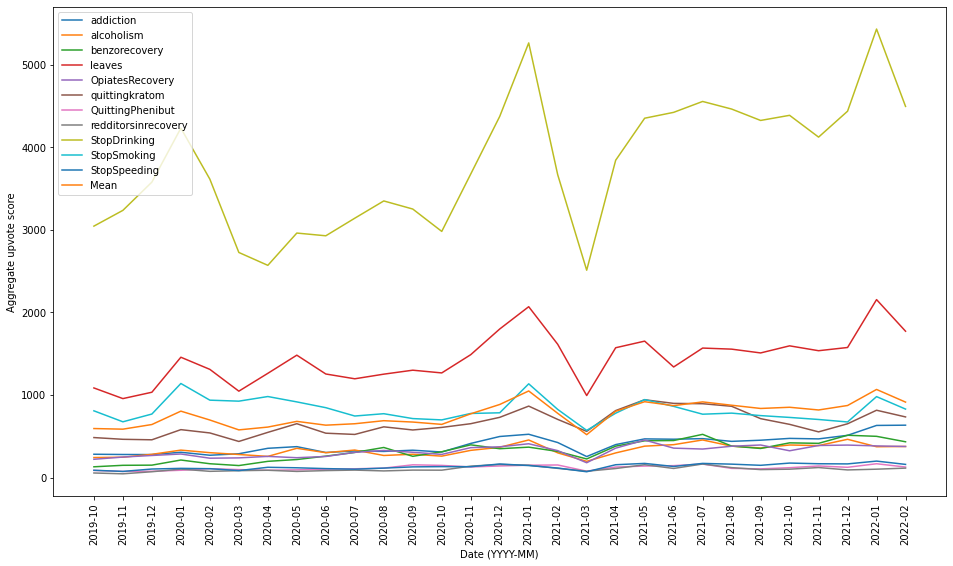

In [56]:
#Only plot one subreddit since this is for demonstration
with tqdm(total=len(subreddits)) as pbar:
    mean_score_stat = list()
    for subreddit in subreddits: 
        pbar.update(1)
        scores_stat = list()
        for date in iter_months(start_year, start_month, end_year, end_month): 
            month_score_list = list()
            df = pd.read_csv(f'data/{subreddit}/{subreddit}_{date["year"]}-{date["month"]}.csv')
            for index, row in df.iterrows():
                month_score_list.append(1)
            scores_stat.append(sum(month_score_list))
        mean_score_stat.append(scores_stat)
        plt.plot(dates, scores_stat, label=subreddit)
        
plt.plot(dates, np.average(mean_score_stat, axis=0), label="Mean")       
plt.legend(loc='upper left')    
plt.xticks(rotation=90)
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Aggregate upvote score')
plt.show()

In [151]:
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist


#Remove punctuation
tokenizer = RegexpTokenizer(r'\w+')

stopwords_set = set(stopwords.words('english'))

#Only plot one subreddit since this is for demonstration    
for subreddit in ["addiction"]: 
    #Only plot one month since this is for demonstration
    for date in iter_months(start_year, start_month, start_year, start_month): 
        print(f'{date["year"]}-{date["month"]}')
        df = pd.read_csv(f'data/{subreddit}/{subreddit}_{date["year"]}-{date["month"]}.csv')
        filtered_words = list()
        for title, body in zip(df.Title, df.Body): 
            text = f'{title}. {body}'
            text = tokenizer.tokenize(text)
            text = ' '.join(word for word in text)
            tokenized_words = [word.lower() for word in word_tokenize(text)]

            #Remove all stopwords
            for word in tokenized_words:
                if word not in stopwords_set:
                    filtered_words.append(word)
                    
        fdist = FreqDist(filtered_words)    
        most_common = fdist.most_common(20)
        #display(most_common)
        ## Conversion to Pandas series via Python Dictionary for easier plotting
        most_common = pd.Series(dict(most_common))
        print(most_common)

        ## Setting figure, ax into variables
        #fig, ax = plt.subplots(figsize=(10,10))

        ## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
        #all_plot = seaborn.barplot(x=most_common.index, y=most_common.values, ax=ax)
        #plt.xticks(rotation=30);
        #plt.show()

2019-10
like         222
get          221
feel         198
know         174
addiction    172
time         170
want         160
years        160
day          151
help         142
would        141
life         134
back         133
even         129
go           125
drugs        125
one          114
people       102
take          98
going         97
dtype: int64


100%|██████████| 11/11 [02:48<00:00, 15.32s/it]


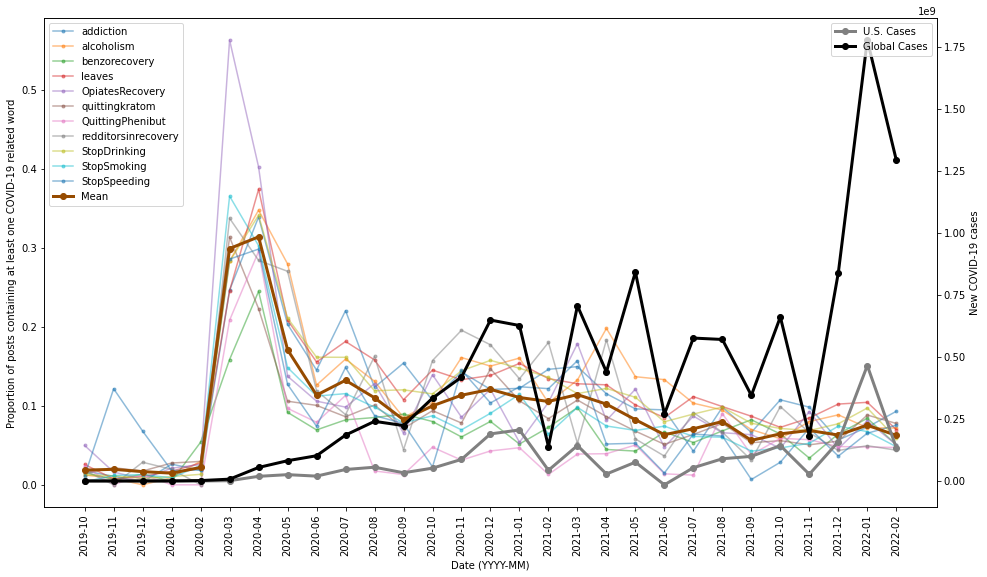

In [52]:
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist


#Remove punctuation
tokenizer = RegexpTokenizer(r'\w+')


plt.rcParams["figure.figsize"] = [16,9]
fig,ax = plt.subplots()

mean_proportion_list = list()

#lets implement a progress bar since this will take some time
with tqdm(total=len(subreddits)) as pbar:
    for subreddit in subreddits: 
        pbar.update(1)
        proportion_list = list()
        for date in iter_months(start_year, start_month, end_year, end_month): 
            df = pd.read_csv(f'data/{subreddit}/{subreddit}_{date["year"]}-{date["month"]}.csv')
            num_mentions = 0
            for title, body in zip(df.Title, df.Body): 
                text = f'{title}. {body}'
                text = tokenizer.tokenize(text)
                text = ' '.join(word for word in text)
                tokenized_words = [word.lower() for word in word_tokenize(text)]
                for e in tokenized_words:
                    for token in COVID_TOKENS:
                        if token in e:
                            num_mentions += 1
            proportion_list.append(num_mentions/len(df))
        mean_proportion_list.append(proportion_list)
        plt.plot(dates, proportion_list, label = subreddit, marker='.', alpha=0.5)

plt.plot(dates, np.average(mean_proportion_list, axis=0), label = "Mean", color ="#964B00", marker='o', linewidth=3) 
plt.legend(loc='upper left')
plt.xticks(rotation=90)


ax.set_xlabel("Date (YYYY-MM)")
ax.set_ylabel("Proportion of posts containing at least one COVID-19 related word")

ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(dates, monthly_us_covid_cases, label = "U.S. Cases", color = "grey", marker='o', linewidth=3)
ax2.plot(dates, monthly_global_covid_cases, label = "Global Cases", color = "black",  marker='o', linewidth=3)
plt.legend(loc='upper right')
ax2.set_ylabel("New COVID-19 cases")
plt.savefig('figures/covid19_mention_vs_new_cases.jpg',bbox_inches='tight', dpi=150)
plt.show()

<hr>

# 3 Sentiment Analysis and Classification

## 3.1 Loading ALBERT

In [154]:
import os

#set`TRANSFORMERS_CACHE` environment variable before importing `transformers` because we prefer the model to download to local folder
os.environ['TRANSFORMERS_CACHE'] = 'transformers_cache/' 

import torch

if torch.cuda.is_available():
    device = 0
else:
    device = -1
    print("PyTorch is unable to access CUDA installation.")
    
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

pipe = pipeline(task="sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device = device)

## 3.2 Perform inference

In [9]:
def data():
    for subreddit in subreddits: 
        for date in iter_months(start_year, start_month, end_year, end_month): 
            df = pd.read_csv(f'data/{subreddit}/{subreddit}_{date["year"]}-{date["month"]}.csv')
            for index, row in df.iterrows():
                yield f'{row["Title"]}. {row["Body"]}'
                
for e in data():
    out = pipe(e, truncation = True)
    print(out)
    if out[0]["label"] == "POSITIVE":
        print(e)

[{'label': 'POSITIVE', 'score': 0.9977933168411255}]
I'm committed to making a change.... Last week I came out to my wife and shared with her my struggles with substance abuse. Surprisingly she was very supportive and asked what she could do to help. I decided to hand her over all of my stash and shared that when I wanted to blaze I would let her know and she'd try to talk me out of it. I really want to change and I'm glad my wife is willing to help.

Wish me luck...
[{'label': 'NEGATIVE', 'score': 0.9993337988853455}]
[{'label': 'NEGATIVE', 'score': 0.9979355335235596}]
[{'label': 'NEGATIVE', 'score': 0.9994215965270996}]
[{'label': 'NEGATIVE', 'score': 0.597956657409668}]
[{'label': 'NEGATIVE', 'score': 0.9816907048225403}]
[{'label': 'POSITIVE', 'score': 0.6930530071258545}]
Anyone wants to celebrate with me?. This week I celebrate my 2 months clean from heroin and one month clean from benzos and self harm. It is not a lot of time but after years of not even seeing the possibility o

KeyboardInterrupt: 